# Plot NeverWorld2 setup (Figure 1)

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cmocean

In [3]:
import xarray as xr
from dask.diagnostics import ProgressBar

In [4]:
run = 'nw2_0.03125deg_N15_baseline_hmix20'
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'

In [5]:
chunks = {'time': 1}
st = xr.open_dataset('%s/%s/static.nc' % (path,run), decode_times=False)
av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')

### Pick last 500 days (i.e., 100 time slices) of data
Consistent with time interval considered in the remainder of this work

In [6]:
av = av.isel(time=slice(-100, None))
av.time

<xarray.DataArray 'time' (time: 100)>
array([2402.5, 2407.5, 2412.5, 2417.5, 2422.5, 2427.5, 2432.5, 2437.5, 2442.5,
       2447.5, 2452.5, 2457.5, 2462.5, 2467.5, 2472.5, 2477.5, 2482.5, 2487.5,
       2492.5, 2497.5, 2502.5, 2507.5, 2512.5, 2517.5, 2522.5, 2527.5, 2532.5,
       2537.5, 2542.5, 2547.5, 2552.5, 2557.5, 2562.5, 2567.5, 2572.5, 2577.5,
       2582.5, 2587.5, 2592.5, 2597.5, 2602.5, 2607.5, 2612.5, 2617.5, 2622.5,
       2627.5, 2632.5, 2637.5, 2642.5, 2647.5, 2652.5, 2657.5, 2662.5, 2667.5,
       2672.5, 2677.5, 2682.5, 2687.5, 2692.5, 2697.5, 2702.5, 2707.5, 2712.5,
       2717.5, 2722.5, 2727.5, 2732.5, 2737.5, 2742.5, 2747.5, 2752.5, 2757.5,
       2762.5, 2767.5, 2772.5, 2777.5, 2782.5, 2787.5, 2792.5, 2797.5, 2802.5,
       2807.5, 2812.5, 2817.5, 2822.5, 2827.5, 2832.5, 2837.5, 2842.5, 2847.5,
       2852.5, 2857.5, 2862.5, 2867.5, 2872.5, 2877.5, 2882.5, 2887.5, 2892.5,
       2897.5])
Coordinates:
  * time     (time) float64 2.402e+03 2.408e+03 ... 2.892e+03 2.898e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS
    bounds:          time_bnds

In [7]:
nr_days = 5 * len(av.time)
nr_days

500

In [8]:
import warnings
warnings.filterwarnings("ignore")

### Compute time-averaged SSH

In [10]:
with ProgressBar():
    SSH = av.e.isel(zi=0).mean(dim='time').compute()

[########################################] | 100% Completed | 53.1s


### Function for constructing wind profile

In [11]:
import numpy as np

def scurve(x, x0, dx):
    """Returns 0 for x<x0 or x>x+dx, and a cubic in between."""
    s = np.minimum(1, np.maximum(0, (x-x0)/dx))
    return (3 - 2*s) * (s*s)
def tau_profile(ytau, taud, ys):
    """Returns wind profile that uses s-curves between (node, value) = (y, tau)"""
    taus = 0. * ys
    ks = 0
    for i in range(len(ys)):
        y = ys[i]
        if y >= ytau[ks+1]:
            ks = min(len(ytau)-2, ks+1)
        taus[i] = taud[ks] + (taud[ks+1] - taud[ks]) * scurve(y, ytau[ks], ytau[ks+1] - ytau[ks])
    return taus


In [12]:
#NW2 wind profile
y, tau = [-70, -45, -15, 0, 15, 45, 70], [0, 0.2, -0.1, -0.02, -0.1, 0.1, 0]
ys = np.linspace(-70,70,100)
profile = tau_profile(y, tau, ys)

## Plotting

In [13]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [14]:
# colormap for SSH
from matplotlib import cm
nr_levels = 12
cmap = cm.get_cmap('PRGn', nr_levels)

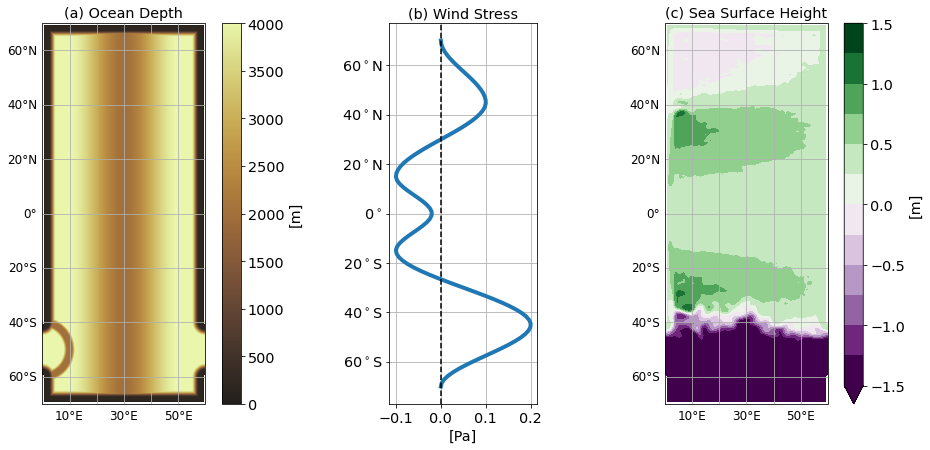

In [16]:
fig = plt.figure(figsize=(17,7))
gs = fig.add_gridspec(1, 11)

# Bathymetry
ax1 = fig.add_subplot(gs[0, :4], projection=ccrs.PlateCarree())

st.depth_ocean.plot(
    ax=ax1,
    cbar_kwargs={"label":   '[m]'},
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.turbid_r,
    vmin=0, vmax=4000
)
ax1.set(title='(a) Ocean Depth')

# Wind profile   
ax2 = fig.add_subplot(gs[0, 5:7])
plt.plot(profile, ys, linewidth=4)
ax2.axvline(0, linestyle='dashed', color='k', linewidth=1.5)
ax2.grid('on')
ax2.set(ylabel='', xlabel='[Pa]', title=r'(b) Wind Stress')
ax2.set_xticks(np.arange(-0.1, 0.21, 0.1))
ax2.set_yticks(np.arange(-60, 70, 20))
ax2.set_yticklabels([r'60$^\circ$S',r'40$^\circ$S',r'20$^\circ$S',r'0$^\circ$',r'20$^\circ$N',r'40$^\circ$N',r'60$^\circ$N'])

# SSH
ax3 = fig.add_subplot(gs[0, 7:11], projection=ccrs.PlateCarree())
SSH.plot(
    ax=ax3,
    cbar_kwargs={"label":   '[m]'},
    cmap=cmap,
    vmin=-1.5, vmax=1.5,
    transform=ccrs.PlateCarree()
)
ax3.set(title='(c) Sea Surface Height')
 
for ax in [ax1, ax3]:
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

fig.subplots_adjust(wspace=0.5)

figname = 'figures/setup.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)